<a href="https://colab.research.google.com/github/Hashan1999/Pig-Weight-Estimation/blob/main/Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision --quiet


In [ ]:
pip install --upgrade triton

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [ ]:
from google.colab import files
uploaded = files.upload()  # choose pig_dataset.zip

KeyboardInterrupt: 

In [ ]:
import zipfile, os

zip_path = "pig_datasetv5.zip"   # if that is the name
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall("/content")

base_dir = "/content/pig_dataset"
print("Base dir:", base_dir, "exists:", os.path.isdir(base_dir))

Base dir: /content/pig_dataset exists: True


In [ ]:
base_dir = "/content/pig_dataset"  # change if your path is different
labels_path = os.path.join(base_dir, "labels.csv")

df_labels = pd.read_csv(labels_path)

# Fix backslashes → forward slashes
df_labels["rgb_path"] = df_labels["rgb_path"].str.replace("\\", "/", regex=False)
df_labels["mask_path"] = df_labels["mask_path"].str.replace("\\", "/", regex=False)

df_labels.head()


,rgb_path,mask_path,target_weight_kg,base_weight_kg,scale,distance_m,angle_deg
0,106kg/rgb/pig_w106kg_n00.png,106kg/mask/pig_w106kg_n00_mask.png,106,93.6,1.042341,3.0,90.956758
1,106kg/rgb/pig_w106kg_n01.png,106kg/mask/pig_w106kg_n01_mask.png,106,93.6,1.042341,3.0,94.887005
2,106kg/rgb/pig_w106kg_n02.png,106kg/mask/pig_w106kg_n02_mask.png,106,93.6,1.042341,3.0,86.367154
3,106kg/rgb/pig_w106kg_n03.png,106kg/mask/pig_w106kg_n03_mask.png,106,93.6,1.042341,3.0,92.774164
4,106kg/rgb/pig_w106kg_n04.png,106kg/mask/pig_w106kg_n04_mask.png,106,93.6,1.042341,3.0,90.952132


In [ ]:
from sklearn.model_selection import train_test_split

rgb_paths = [os.path.join(base_dir, p) for p in df_labels["rgb_path"]]
mask_paths = [os.path.join(base_dir, p) for p in df_labels["mask_path"]]

train_rgb, val_rgb, train_mask, val_mask = train_test_split(
    rgb_paths, mask_paths, test_size=0.2, random_state=42
)

len(train_rgb), len(val_rgb)


(64, 16)

In [ ]:
class PigInstanceDataset(Dataset):
    def __init__(self, rgb_paths, mask_paths, transforms=None):
        self.rgb_paths = rgb_paths
        self.mask_paths = mask_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.rgb_paths)

    def __getitem__(self, idx):
        rgb_path = self.rgb_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image
        img = cv2.imread(rgb_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load mask (grayscale)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None or img is None:
            raise RuntimeError(f"Failed to load image or mask at index {idx}")

        # Binary mask (0 or 1)
        _, mask_bin = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
        mask_bin = (mask_bin > 0).astype(np.uint8)

        # Compute bounding box from mask
        ys, xs = np.where(mask_bin == 1)
        if len(xs) == 0 or len(ys) == 0:
            # Degenerate mask; avoid crash
            xmin, ymin, xmax, ymax = 0, 0, img.shape[1]-1, img.shape[0]-1
        else:
            xmin, xmax = xs.min(), xs.max()
            ymin, ymax = ys.min(), ys.max()

        boxes = np.array([[xmin, ymin, xmax, ymax]], dtype=np.float32)
        masks = mask_bin[np.newaxis, :, :]  # (1, H, W)

        labels = np.array([1], dtype=np.int64)  # class "pig" = 1
        image_id = np.array([idx])
        area = (xmax - xmin + 1) * (ymax - ymin + 1)
        iscrowd = np.array([0], dtype=np.int64)

        # Convert to torch tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.as_tensor(image_id, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target


In [ ]:
def get_transform(train=True):
    transforms = []
    # Our img is already 0–1 tensor, so we don't need ToTensor
    # But we can add random flip for training:
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [ ]:
train_dataset = PigInstanceDataset(train_rgb, train_mask, transforms=get_transform(train=True))
val_dataset   = PigInstanceDataset(val_rgb,   val_mask,   transforms=get_transform(train=False))

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True,
    num_workers=2, collate_fn=collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=2, shuffle=False,
    num_workers=2, collate_fn=collate_fn
)


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Load pretrained model
model = maskrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 2  # 1 class (pig) + background

# Replace box predictor
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Replace mask predictor
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask,
    hidden_layer,
    num_classes
)

model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [ ]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=1e-4)

num_epochs = 5  # start small; you can increase

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for imgs, targets in train_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += float(losses)

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - train loss: {avg_loss:.4f}")


/tmp/ipython-input-3241386223.py:23: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  epoch_loss += float(losses)


Epoch 1/5 - train loss: 0.6177
Epoch 2/5 - train loss: 0.1407
Epoch 3/5 - train loss: 0.0983
Epoch 4/5 - train loss: 0.0980
Epoch 5/5 - train loss: 0.0819


In [ ]:
model.eval()

# take first val sample
test_img_path = val_rgb[0]
test_mask_path = val_mask[0]

# load image as tensor like in dataset (but no transform)
img = cv2.imread(test_img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0

with torch.no_grad():
    prediction = model([img_tensor.to(device)])

prediction


[{'boxes': tensor([[435.6735, 247.8100, 849.5338, 475.5574]], device='cuda:0'),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9991], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')}]

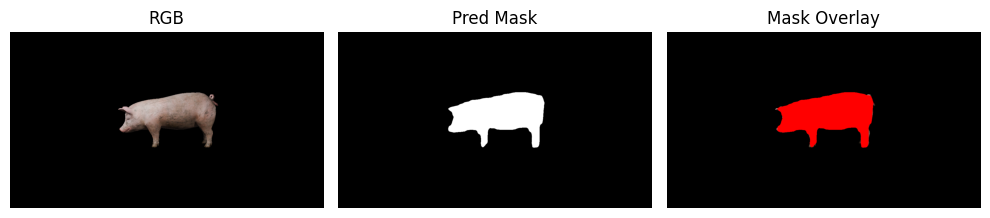

In [ ]:
# Get predicted mask for the first detected instance (if any)
pred = prediction[0]
scores = pred["scores"].cpu().numpy()

if len(scores) == 0 or scores[0] < 0.5:
    print("No high-confidence pig detected.")
else:
    best_mask = pred["masks"][0, 0].cpu().numpy()  # (H, W)
    best_mask_bin = (best_mask > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,4))
    plt.subplot(1,3,1)
    plt.title("RGB")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Pred Mask")
    plt.imshow(best_mask_bin, cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Mask Overlay")
    overlay = img_rgb.copy()
    overlay[best_mask_bin==1] = [255, 0, 0]
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
save_path = "/content/mask_rcnn_pig.pth"
torch.save(model.state_dict(), save_path)
print("Saved model to:", save_path)


Saved model to: /content/mask_rcnn_pig.pth
